# Aula 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Funções pra criação dos datasets e para fazer os gráficos

In [2]:
def criaDatasetClassificacao(n=20, slop=[2,1], intercept=-0.4):
    X = np.random.uniform(size=(n,2)) # cria a matriz 20x2
    AUX = np.multiply(X, slop) - [0,intercept] # multiplica X1 por 2 e X2 por 1 e soma o intercept ao X2
    y = (AUX[:,0]>AUX[:,1])*2-1 # y vale 1 ou -1, a depender da reta (slop e intercept)
    return X,y

def criaDatasetRegressao(n=20, slope=0.5, intercept=0.2):
    X = np.random.uniform(size=(n,1)) #cria uma matriz 20x1
    AUX = np.random.rand(n,1)-0.5   #adicionar um ruído
    y = X*slope + intercept + AUX*0.1
    y = y.flatten()  #retorna vetor, não matriz
    return X,y

def criaDatasetRegularizacao(n=20, slop=[2,1], intercept=-0.4, dummy_features=3):
    X = np.random.uniform(size=(n, dummy_features+2))
    AUX = np.multiply(X[:,:2], slop) - [0, intercept] #multiply é a multiplicação de matriz # aqui são adicionados os ruídos
    y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
    return X, y

def plotDataset(X, y):
    plt.xlabel('x1')
    plt.ylabel('x2')

    for k in set(y):
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o", alpha=0.3)

def plotHiperplano(X, y, vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])

    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0]/vetor[1])*xs - intercept/vetor[1]

    plt.plot(xs, ys)

def plotDatasetRegr(X,y):
    plt.plot(X[:,0], y, "o", alpha=0.3) #pega uma parte do X pq o X é uma matriz e queremos usar o vetor

def plotaFuncao(X, y, slop, intercept=0):
    xmin = min(X)
    xmax = max(X)
    xs = np.linspace(xmin, xmax, num=2)
    ys = xs*slop + intercept
    plt.plot(xs, ys)

def PlotCusto(custos):
    '''
    Plotando o gráfico de iterações x custo para aprendizado.
    '''
    if (len(custos) == 0):
        print('ERRO: Modelo ainda não treinado para avaliar o custo!')
        return
    
    x = [i for i in range(1,len(custos) + 1)]

    plt.xlabel('Nº Iterações')
    plt.ylabel('Custo')
    plt.plot(x, custos, "-")
    plt.show()

### Funções das aulas anteriores

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod
import random

def sign(a): #função de ativação
    return (a>=0)*2-1

def accuracy(yactual, ypred):
    return sum(yactual==ypred)/len(yactual)

class trainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y): #ele pôs mas tirou o activation
        pass

### Novas classes de custo

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod, abstractstaticmethod
import random

class Custo(ABC):
    '''
    Classe de custo
    '''
    @abstractstaticmethod
    def custo(self, y, ypred):
        pass

    @abstractstaticmethod
    def gradiente(self, y, ypred):
        pass

### Função WidrowHoff

In [5]:
class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((y-ypred)**2)
    @staticmethod
    def gradiente(y, ypred):
        return y-ypred

### Descida do Gradiente

In [6]:
class DescidaGradiente(trainingAlgorithm):
    def __init__(self, max_iter=100, learning_rate=0.02, regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost
        self.custos = []

    def getW(self, X, y):
        w =np.random.uniform(-1,1,size=(X.shape[1],y.shape[1])) #começa com um vetor de pesos aleatórios
        for _ in range(self.max_iter):
            ypred = X @ w
            c = self.cost.custo(y, ypred) 
            self.custos.append(c)
            if c==0:
                break
            w *= 1-self.regularization*self.learning_rate
            w += (X.T @ self.cost.gradiente(y, ypred))*self.learning_rate
        return w

### Pseudo Inversa

In [7]:
class PseudoInversa(trainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
    
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        else:
            '''
            a formula matematica: (X'X + I*r)^(-1) X'y
            '''
            f1 = (X.T @ X)
            I = np.identity(f1.shape[0])
            f2 = I*self.regularization
            print('f1',f1)
            print('f2',f2)
            fator = f1 + f2
            
            w = np.linalg.pinv(fator) @ X.T * y
            return w

### Perceptron

In [8]:
class Perceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
        
    def __pre_activation(self, X):
        Xb = self.includeBias(X)
        
        return Xb @ self.w
    
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        
        return Xb
        
    def predict(self, X, y=None):
        
        a = self.__pre_activation(X)
        ypred = self.activation(a)
        
        return ypred
    
    
    def fit(self, X, y):
        '''
        Treinamento do perceptron.
        '''

        Xb = Perceptron.includeBias(X)
        self.w = self.training_algorithm.getW(Xb, y)

### SmoothedSurrogate

In [9]:
class SmoothedSurrogate(Custo):
    '''
    Função de custo cujo gradiente utiliza o mesmo método do PLA Perseptron inicial (Aula1), mas
    a função de custo é calculada de forma diferente.

    custo = - y * ypred
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), -y*ypred))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - sign(ypred)

### LogLikehood

In [10]:
from scipy.special import expit

class LogLikehood(Custo):
    '''
    
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - (expit(ypred)*2 -1 )

### HingeLoss

In [11]:
class HingeLoss(Custo):
    '''
    Função de custo tende a considerar quem está mais próximo do hiperplano.
    custo -> 1 - y * ypred
    gradiente -> considera os erros negativos com maior rigor que os positivos, de forma a penalizar
    o algoritmo quando erra muito negativamente (errosmarginais) 
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - (y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        #filtro para encontrar os erros marginais
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        
        #zerando todos os erros que não são marginais
        #invertendo os indices, 
        ymarginais[~errosmarginais] = 0 

        return ymarginais

In [12]:
from sklearn.datasets import make_blobs

#criar um dataset para problemas multiclasse
#por padrão, ele só tem 2 características
#cada vez que roda, os blobs vão ficar em lugares diferentes
def criaDatasetMulticlasse(n=1000,n_classes=4):
    X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1),cluster_std=0.02)
    return X,y

In [50]:
from sklearn.model_selection import train_test_split

X,y = criaDatasetMulticlasse()
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)

In [51]:
def plotDataset(X, y):
    plt.xlabel('x1')
    plt.ylabel('x2')

    for k in set(y):
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o", alpha=0.3)

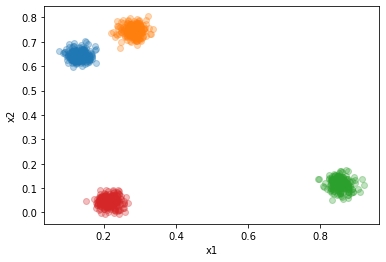

In [52]:
plotDataset(Xte,yte)

In [16]:
from sklearn.preprocessing import label_binarize

class PerceptronMulticlasse(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
        
    def __pre_activation(self, X):
        Xb = self.includeBias(X)
        return Xb @ self.w
    
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb
        
    #fazendo a rede dentro  de estimator, 
    def predict(self, X, y=None):
        a = self.__pre_activation(X)
        if self.w.shape[1]==1: #se ele tiver só uma coluna 
            idx = np.array(a>0,dtype=int).reshape((-1,)) #problema de 2 classes
        else:
            idx = np.argmax(a,axis=1)
        ypred = np.array([self.labels[i] for i in idx]) #pega a coluna de maior probabilidade
        return ypred
    
    def fit(self, X, y):
        yhot = self.encode_labels(y) #não usar as classes qdo o problema é multiclasse, fazer o one-hot-encode
        Xb = PerceptronMulticlasse.includeBias(X) #essas duas linhas são pre tratamentos
        self.w = self.training_algorithm.getW(Xb,yhot)

    def encode_labels(self,y):
        self.labels = list(set(y)) #é muito eficiente de se fazer isso em python
        return label_binarize(y,classes=self.labels)*2-1 #para a saída não ser 0 e 1, e sim -1 e 1

### Usando a função de custo de Hinge Loss e uma base multiclasse

0.9911111111111112


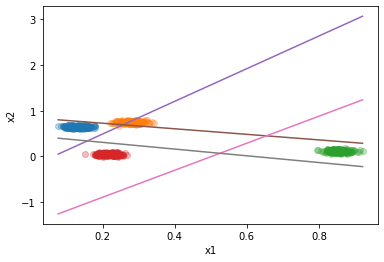

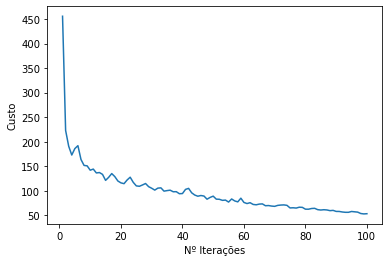

In [53]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=HingeLoss()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataset(X, y)
#plotHiperplano(X,y,percep.w[1:], percep.w[0])
if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

### Usando a função de custo de Smoothed Surrogate e uma base multiclasse

1.0


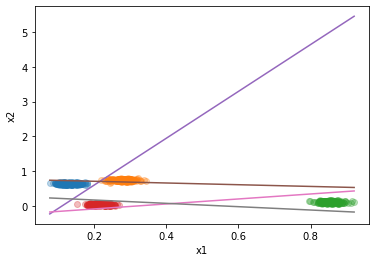

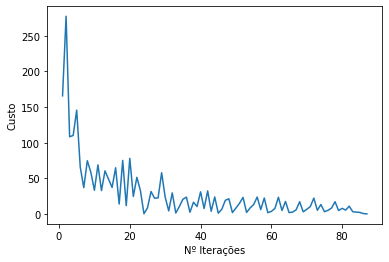

In [54]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataset(X, y)
#plotHiperplano(X,y,percep.w[1:], percep.w[0])
if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

In [55]:
print(percep.w)

[[ 0.85137677 -1.7282211  -0.35019265  0.27206025]
 [-7.70059463  0.5608994   1.11095974 -0.48331467]
 [ 1.14482701  2.27081082 -1.5514411  -1.00867165]]


### Usando a função de custo de Hinge Loss e uma base binária

In [58]:
X,y = criaDatasetMulticlasse(n_classes=2)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)

1.0


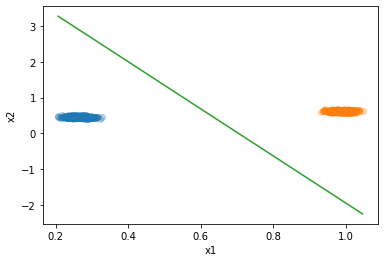

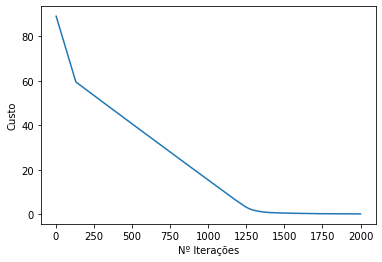

In [59]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=HingeLoss, learning_rate=0.0001, max_iter=2000, regularization=0.1))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataset(X, y)
#plotHiperplano(X,y,percep.w[1:], percep.w[0])
for i in range(percep.w.shape[1]):
    plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

### Usando a função de custo de Smoothed Surogated e uma base binária

1.0


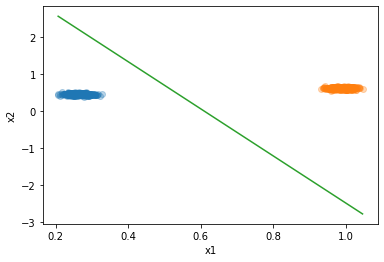

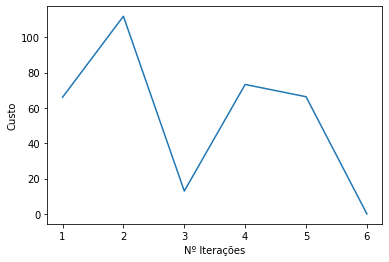

In [61]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataset(X, y)
#plotHiperplano(X,y,percep.w[1:], percep.w[0])
if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)